# BrainNetCNN 
version 1 <br>
Software by **Amine Echraibi**<br>
This notebook implements the method described [Here](http://www.sciencedirect.com/science/article/pii/S1053811916305237) and verifies the results. <br>
This is a re-implementation in Keras Tensorflow backend, of the neural net described in the paper.


In [1]:
from __future__ import print_function, division
import matplotlib.pyplot as plt
plt.interactive(False)
import tensorflow as tf
import h5py
from scipy.stats import pearsonr
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras import optimizers, callbacks, regularizers, initializers
from E2E_conv import *
from injury import ConnectomeInjury
import numpy as np
from vis.visualization import visualize_activation
from keras.utils import to_categorical
from nilearn import datasets
from nilearn import input_data
from nilearn.connectome import ConnectivityMeasure

Using TensorFlow backend.


Setting up the hyper parameters, and l2 regularizer




In [2]:
# Globals : Hyperparamaters
batch_size = 14
dropout = 0.5
momentum = 0.9
noise_weight = 0.0625
lr = 0.01
decay = 0.0005

# Setting l2_norm regularizer
reg = regularizers.l2(decay)
kernel_init = initializers.he_uniform()

 ## Representation of syntheticly generated connectome
 ### Generating data
 

In [3]:
# Loading synthetic data
injuryconnectome = ConnectomeInjury()
x_train,y_train = injuryconnectome.generate_injury(n_samples=1000,noise_weight=noise_weight)
x_valid,y_valid = injuryconnectome.generate_injury(n_samples=300,noise_weight=noise_weight)


### ploting a synthetic connectome


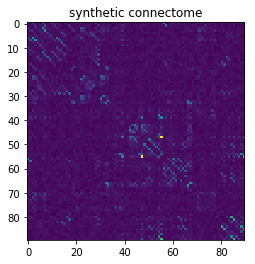

The adjacency matrix : 
[[ 0.04707884  0.03092055  0.14618641 ...,  0.02760327  0.0438556
   0.03770889]
 [ 0.03092055  0.03429337  0.04287777 ...,  0.01300712  0.03443554
   0.01435285]
 [ 0.14618641  0.04287777  0.00859312 ...,  0.05135169  0.03395176
   0.01405274]
 ..., 
 [ 0.02760327  0.01300712  0.05135169 ...,  0.01938141  0.01424499
   0.16146842]
 [ 0.0438556   0.03443554  0.03395176 ...,  0.01424499  0.04410799
   0.03664002]
 [ 0.03770889  0.01435285  0.01405274 ...,  0.16146842  0.03664002
   0.01110039]]


In [4]:
# ploting a sample
%matplotlib inline
plt.imshow(x_train[0][0])
plt.title('synthetic connectome')
plt.show()
print("The adjacency matrix : ")
print(x_train[0][0])


# reshaping data
x_train = x_train.reshape(x_train.shape[0],x_train.shape[3],x_train.shape[2],x_train.shape[1])
x_valid = x_valid.reshape(x_valid.shape[0],x_valid.shape[3],x_valid.shape[2],x_valid.shape[1])

the synthetic connectome is represented as a graph $G(A,\Omega)$ where : <br> 
- $\Omega$ is the set of nodes each node represents a region of the brain.
- $ A $ is the weighted adjency matrix of the adges representing the strength of the connections between the regions.

## Constructing the new layers
### E2E layer 
$$ A^{l+1,n}_{i,j} = \sum_{k=1}^{|\Omega|} \sum_{m=1}^{M^{l}}[ r_k^{l,m,n}A_{i,k}^{l,m} +   c_k^{l,m,n}A_{k,j}^{l,m}] $$
To construct this layer, we must create two kernels corresponding to r and c of size $1x|\Omega|$ and $|\Omega|x1$ respectively, we then convolve with the output filters, duplicate them $|\Omega|$ times than sum the duplications elementwize to create the convolution discribed above.

In [5]:
# Construction of the Edge-2-Edge layer using Keras backend.
# -*- coding: utf-8 -*-

from keras import backend as K
from keras import activations
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.engine import Layer
from keras.engine import InputSpec
from keras.utils import conv_utils

class E2E_conv(Layer):
    def __init__(self, rank,
                 filters,
                 kernel_size,
                 strides=1,
                 padding='valid',
                 data_format=None,
                 dilation_rate=1,
                 activation=None,
                 use_bias=False,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(E2E_conv, self).__init__(**kwargs)
        self.rank = rank
        self.filters = filters
        self.kernel_size = conv_utils.normalize_tuple(kernel_size, rank, 'kernel_size')
        self.strides = conv_utils.normalize_tuple(strides, rank, 'strides')
        self.padding = conv_utils.normalize_padding(padding)
        self.data_format = conv_utils.normalize_data_format(data_format)
        self.dilation_rate = conv_utils.normalize_tuple(dilation_rate, rank, 'dilation_rate')
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(ndim=self.rank + 2)

    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True

    def call(self, inputs):
        kernel_shape=K.get_value(self.kernel).shape
        d=kernel_shape[1]
        kernel1xd = K.reshape(self.kernel[0,:],(1,kernel_shape[1],kernel_shape[2],kernel_shape[3]))
        kerneldx1 = K.reshape(self.kernel[1,:], (kernel_shape[1],1, kernel_shape[2], kernel_shape[3]))
        conv1xd = K.conv2d(
            inputs,
            kernel1xd,
            strides=self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate)
        convdx1 = K.conv2d(
                inputs,
                kerneldx1,
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)
        concat1 = K.concatenate([convdx1]*d,axis=1)
        concat2 = K.concatenate([conv1xd]*d,axis=2)
        return concat1+concat2

    def compute_output_shape(self, input_shape):
        return (input_shape[0],input_shape[1],input_shape[2],self.filters)

    def get_config(self):
        config = {
            'rank': self.rank,
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            'strides': self.strides,
            'padding': self.padding,
            'data_format': self.data_format,
            'dilation_rate': self.dilation_rate,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(E2E_conv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

**N.b.** the previous cell is here to show how the E2E layer was implemented as a keras layer. 

To use the layer, simply do:

In [6]:
from E2E_conv import *

### E2N layer 
$$a^{l+1,n}_i = \sum_{k=1}^{|\Omega|} \sum_{m=1}^{M^{l}}[ r_k^{l,m,n}A_{i,k}^{l,m} +   c_k^{l,m,n}A_{k,i}^{l,m}]$$
A simple 1-D convolution. Code in model architecture 

### E2N layer 
$$ a^{l+1,n} = \sum_{k=1}^{|\Omega|} \sum_{m=1}^{M^{l}} w_k^{l,m,n}a_{i}^{l,m}$$
A simple 1-D convolution. Code in model architecture 

## Creating the model
### Description :
![alt text](screen1.png "Description of the different layers")
l2_regularization was introduced in every layer. 
Dropout of 0.5 was introduced for every layer after N2G layer.
The Activation uses very leaky rectified linear units '$\alpha=0.33$'.


In [ ]:
# Model architecture 

model = Sequential()
model.add(E2E_conv(2,32,(2,90),kernel_regularizer=reg,input_shape=(90,90,1),input_dtype='float32',data_format="channels_last"))
print("First layer output shape :"+str(model.output_shape))
model.add(LeakyReLU(alpha=0.33))
#print(model.output_shape)
model.add(E2E_conv(2,32,(2,90),kernel_regularizer=reg,data_format="channels_last"))
print(model.output_shape)
model.add(LeakyReLU(alpha=0.33))
model.add(Convolution2D(64,(1,90),kernel_regularizer=reg,data_format="channels_last"))
model.add(LeakyReLU(alpha=0.33))
model.add(Convolution2D(256,(90,1),kernel_regularizer=reg,data_format="channels_last"))
model.add(LeakyReLU(alpha=0.33))
#print(model.output_shape)
model.add(Dropout(0.5))
model.add(Dense(128,kernel_regularizer=reg,kernel_initializer=kernel_init))
#print(model.output_shape)
model.add(LeakyReLU(alpha=0.33))
#print(model.output_shape)
model.add(Dropout(0.5))
model.add(Dense(30,kernel_regularizer=reg,kernel_initializer=kernel_init))
model.add(LeakyReLU(alpha=0.33))
#print(model.output_shape)
model.add(Dropout(0.5))
model.add(Dense(2,kernel_regularizer=reg,kernel_initializer=kernel_init))
model.add(Flatten())
model.add(LeakyReLU(alpha=0.33))
model.summary()
#print(model.output_shape)

## Training The model
- We use the euclidean distance as a cost function
- The evaluation metric is the mean absolute error

## Generating the results

In [20]:
from injury import ConnectomeInjury
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error as mae
from numpy import std
from IPython.display import HTML, display
import tabulate

def generate_synthetic_validation_data(noise):
    injury = ConnectomeInjury() # Generate train/test synthetic data.
    x_valid_y_valid = injury.generate_injury(n_samples=300, noise_weight=noise)
    return x_valid_y_valid


def get_results_from_models(model,noises):
    results = [["noises"]+noises,
               ["mae_alpha"],
               ["stdae_alpha"],9
               ["mae_beta"],
               ["stdae_beta"],
               ["r_alpha"],
               ["r_beta"]]
    for i in range(len(noises)):
        noise = noises[i]
        x_valid, y_valid = generate_synthetic_validation_data(noise)
        x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[3], x_valid.shape[2], x_valid.shape[1])
        # load weights into new model
        model.load_weights("Weights/BrainCNNWeights_noise_"+str(noise)+".h5")
        print("Loaded model from disk")
        preds = model.predict(x_valid)
        results[1].append("{0:.2f}".format(100*mae(preds[:,0],y_valid[:,0])))
        results[2].append("{0:.2f}".format(100*std(abs(y_valid[:, 0] - preds[:, 0]))))
        results[3].append("{0:.2f}".format(100*mae(preds[:, 1], y_valid[:, 1])))
        results[4].append("{0:.2f}".format(100*std(abs(y_valid[:,1]-preds[:,1]))))
        results[5].append("{0:.2f}".format(pearsonr(preds[:,0],y_valid[:,0])[0]))
        results[6].append("{0:.2f}".format(pearsonr(preds[:, 1], y_valid[:, 1])[0]))
    display(HTML(tabulate.tabulate(results, tablefmt='html')))

## Main function
can be run in two modes the training mode where we train the model on the genrated data above (set the desired noise weight above), or the predicting mode where we run our generated trained model on different noise weights and display the results.

In [ ]:
opt = optimizers.SGD(momentum=momentum,nesterov=True,lr=lr)
model.compile(optimizer=opt,loss='mean_squared_error',metrics=['mae'])
csv_logger = callbacks.CSVLogger('BrainCNN.log')
command = str(raw_input("Train or predict ? [t/p] "))
if command == "t":
    print("Training for noise = "+str(noise_weight))
    history=model.fit(x_train,y_train,nb_epoch=1000,verbose=1,callbacks=[csv_logger])
    model.save_weights("Weights/BrainCNNWeights_noise_"+str(noise_weight)+".h5")
else:
    print("[*] Predicting and printing results for the models trained :")
    get_results_from_models(model,noises = [0,0.0625,0.125,0.25])

the table above describes the results of the mean absolute error, standard deviation absolute error, and correlation for each of the parameters alpha and beta for different levels of noise.
#### Conclusion: 
The table above verifies the results described in the paper.

## Verifying the visualization methode "Activation-Maximization"

### generating synthetic data

In [7]:
# generating injury signitures S_1 ans S_2

def get_symmetric_noise(m, n):
    """Return a random noise image of size m x n with values between 0 and 1."""

    # Generate random noise image.
    noise_img = np.random.rand(m, n)

    # Make the noise image symmetric.
    noise_img = noise_img + noise_img.T

    # Normalize between 0 and 1.
    noise_img = (noise_img - noise_img.min()) / (noise_img.max() - noise_img.min())

    assert noise_img.max() == 1  # Make sure is between 0 and 1.
    assert noise_img.min() == 0
    assert (noise_img.T == noise_img).all()  # Make sure symmetric.

    return noise_img

def simulate_injury(X, weight_A, sig_A):
    denom = (np.ones(X.shape) + (weight_A * sig_A))
    X_sig_AB = np.divide(X, denom)
    return X_sig_AB

def apply_injury_and_noise(X, Sig_A, weight_A,noise_weight):
    """Returns a symmetric, signed, noisy, adjacency matrix with simulated injury from two sources."""
    X_sig_AB = simulate_injury(X, weight_A, Sig_A)
    # Get the noise image.
    noise_img = get_symmetric_noise(X.shape[0], X.shape[1])

    # Weight the noise image.
    weighted_noise_img = noise_img * noise_weight

    # Add the noise to the original image.
    X_sig_AB_noise = X_sig_AB + weighted_noise_img
    

    assert (X_sig_AB_noise[0,:,:].T == X_sig_AB_noise[0,:,:]).all()  # Make sure still is symmetric.

    return X_sig_AB_noise


def generate_injury_signatures(X_mn, r_state,sig_indexes):
        """Generates the signatures that represent the underlying signal in our synthetic experiments.

        d : (integer) the size of the input matrix (assumes is size dxd)
        """

        # Get the strongest regions, which we will apply simulated injuries
        sig_indexes = sig_indexes
        d = X_mn.shape[0]

        S = []

        # Create a signature for
        for idx, sig_idx in enumerate(sig_indexes):
            # Okay, let's make some signature noise vectors.
            A_vec = r_state.rand((d))
            # B_vec = np.random.random((n))

            # Create the signature matrix.
            A = np.zeros((d, d))
            A[:, sig_idx] = A_vec
            A[sig_idx, :] = A_vec
            S.append(A)
            
            assert (A.T == A).all()  # Check if matrix is symmetric.

        return np.asarray(S)
def sample_injury_strengths(n_samples, X_mn, A, noise_weight):
        """Returns n_samples connectomes with simulated injury from two sources."""
        mult_factor = 10

        n_classes = 1

        # Range of values to predict.
        n_start = 0.5
        n_end = 1.4
        # amt_increase = 0.1

        # These will be our Y.
        A_weights = np.random.uniform(n_start, n_end, [n_samples])

        X_h5 = np.zeros((n_samples, 1, X_mn.shape[0], X_mn.shape[1]), dtype=np.float32)
        Y_h5 = np.zeros((n_samples, n_classes), dtype=np.float32)

        for idx in range(n_samples):
            w_A = A_weights[idx]

            # Get the matrix.
            X_sig = apply_injury_and_noise(X_mn, A, w_A * mult_factor, noise_weight)

            # Normalize.
            X_sig = (X_sig - X_sig.min()) / (X_sig.max() - X_sig.min())

            # Put in h5 format.
            X_h5[idx, 0, :, :] = X_sig
            Y_h5[idx, :] = [w_A]

        return X_h5, Y_h5
    
def load_base_connectome():
    X_mn = scipy.io.loadmat("data/base.mat")
    X_mn = X_mn['X_mn']
    return X_mn

## Using Adhd data for visualization


### Downloading data

In [8]:
adhd_data = datasets.fetch_adhd(n_subjects=20)
msdl_data = datasets.fetch_atlas_msdl()
msdl_coords = msdl_data.region_coords

masker = input_data.NiftiMapsMasker(
    msdl_data.maps, resampling_target="data", t_r=2.5, detrend=True,
    low_pass=.1, high_pass=.01, memory='nilearn_cache', memory_level=1)
adhd_subjects = []
pooled_subjects = []
site_names = []
adhd_labels = []  # 1 if ADHD, 0 if control
for func_file, confound_file, phenotypic in zip(
        adhd_data.func, adhd_data.confounds, adhd_data.phenotypic):
    time_series = masker.fit_transform(func_file, confounds=confound_file)
    pooled_subjects.append(time_series)
    is_adhd = phenotypic['adhd']
    if is_adhd:
        adhd_subjects.append(time_series)

    site_names.append(phenotypic['site'])
    adhd_labels.append(is_adhd)

conn_measure = ConnectivityMeasure(kind="tangent")
X = conn_measure.fit_transform(pooled_subjects)
Y = np.array(adhd_labels,dtype="float32")

### Setting up the network architecture

in this section we will create two sets of data control using a mean connectome for adhd control patients plus noise, and a simulated test with injury using the mean connectome. than we will train brainnetcnn to predict wether a sample is in control or test in order to visualize wether or not it can extract the brain injury pattern that we introduced on the test dataset using keras-vis.


In [9]:
# Hyper parameters

batch_size = 14
dropout = 0.5
momentum = 0.9
lr = 0.001
decay = 0.0005
noise_weight = 0.0625

reg = regularizers.l2(decay)
kernel_init = initializers.he_uniform()

# Model architecture

model = Sequential()
model.add(E2E_conv(2,8,(2,39),kernel_regularizer=reg,input_shape=(39,39,1),input_dtype='float32',data_format="channels_last"))
print("First layer output shape :"+str(model.output_shape))
model.add(LeakyReLU(alpha=0.33))
#print(model.output_shape)
print(model.output_shape)
model.add(LeakyReLU(alpha=0.33))
model.add(Convolution2D(32,(1,39),kernel_regularizer=reg,data_format="channels_last"))
model.add(LeakyReLU(alpha=0.33))
model.add(Convolution2D(90,(39,1),kernel_regularizer=reg,data_format="channels_last"))
model.add(LeakyReLU(alpha=0.33))
#print(model.output_shape)
model.add(Dropout(0.5))
model.add(Dense(64,kernel_regularizer=reg,kernel_initializer=kernel_init))
#print(model.output_shape)
model.add(LeakyReLU(alpha=0.33))
#print(model.output_shape)
model.add(Dropout(0.5))
model.add(Dense(10,kernel_regularizer=reg,kernel_initializer=kernel_init))
model.add(LeakyReLU(alpha=0.33))
#print(model.output_shape)
model.add(Dropout(0.5))
model.add(Dense(2,activation = "softmax",kernel_regularizer=reg,kernel_initializer=kernel_init))
model.add(Flatten())
model.summary()
#print(model.output_shape)


opt = optimizers.SGD(nesterov=True,lr=lr)
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])
csv_logger = callbacks.CSVLogger('predict_age.log')

kernel_shape : (2, 39, 1, 8)
data shape : (?, 39, 39, 1)
(1, 39, 1, 8)
(39, 1, 1, 8)
cat1(?, 39, 39, 8)
cat2<dtype: 'float32'>
First layer output shape :(None, 39, 39, 8)
(None, 39, 39, 8)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
e2e_conv_1 (E2E_conv)        (None, 39, 39, 8)         624       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 39, 39, 8)         0         
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 39, 39, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 39, 1, 32)         10016     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 39, 1, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)  

In [12]:

control = X[Y==0]
print(control.shape)
r_state = np.random.RandomState(41)
base_connectome = control.mean(axis=0)
base_connectome = (base_connectome.T + base_connectome)/2
S = generate_injury_signatures(X_mn=base_connectome,r_state=r_state,sig_indexes=[5])
X1,Y = sample_injury_strengths(1000,base_connectome,S,noise_weight)
S = generate_injury_signatures(X_mn=base_connectome,r_state=r_state,sig_indexes=[30])
X2,Y = sample_injury_strengths(1000,base_connectome,S,noise_weight)

(7, 39, 39)


In [13]:
X = np.concatenate([X1,X2],axis=0)
print(X.shape)
X = X.reshape(X.shape[0],X.shape[2],X.shape[3],1)
print(X.shape)
Y1 = np.array([1]*1000)
Y2 = np.array([0]*1000)
Y = np.concatenate([Y1,Y2],axis=0)
Y = to_categorical(Y,2)
print(Y.shape)

(2000, 1, 39, 39)
(2000, 39, 39, 1)
(2000, 2)


In [14]:
model.fit(X,Y,batch_size=14,nb_epoch=1000,verbose=1,callbacks=[csv_logger])
model.save_weights("Weights/BrainCNNWeights_Visualization.h5")

/home/amine/.local/lib/python2.7/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/1000
2000/2000 [==============================] - 2s - loss: 0.7998 - acc: 0.5095     
Epoch 2/1000
2000/2000 [==============================] - 1s - loss: 0.7990 - acc: 0.5115     
Epoch 3/1000
2000/2000 [==============================] - 1s - loss: 0.7972 - acc: 0.5340     
Epoch 4/1000
2000/2000 [==============================] - 1s - loss: 0.7974 - acc: 0.5470     
Epoch 5/1000
2000/2000 [==============================] - 1s - loss: 0.7964 - acc: 0.5425     
Epoch 6/1000
2000/2000 [==============================] - 1s - loss: 0.7940 - acc: 0.5705     
Epoch 7/1000
2000/2000 [==============================] - 1s - loss: 0.7917 - acc: 0.5860     
Epoch 8/1000
2000/2000 [==============================] - 1s - loss: 0.7906 - acc: 0.5670     
Epoch 9/1000
2000/2000 [==============================] - 1s - loss: 0.7905 - acc: 0.5750     
Epoch 10/1000
2000/2000 [==============================] - 1s - loss: 0.7887 - acc: 0.5990     
Epoch 11/1000
2000/2000 [========================

2000/2000 [==============================] - 1s - loss: 0.1445 - acc: 0.9895     
Epoch 87/1000
2000/2000 [==============================] - 1s - loss: 0.1421 - acc: 0.9905     
Epoch 88/1000
2000/2000 [==============================] - 1s - loss: 0.1426 - acc: 0.9890     
Epoch 89/1000
2000/2000 [==============================] - 1s - loss: 0.1353 - acc: 0.9935     
Epoch 90/1000
2000/2000 [==============================] - 1s - loss: 0.1418 - acc: 0.9905     
Epoch 91/1000
2000/2000 [==============================] - 1s - loss: 0.1422 - acc: 0.9850     
Epoch 92/1000
2000/2000 [==============================] - 2s - loss: 0.1386 - acc: 0.9910     
Epoch 93/1000
2000/2000 [==============================] - 1s - loss: 0.1390 - acc: 0.9915     
Epoch 94/1000
2000/2000 [==============================] - 1s - loss: 0.1402 - acc: 0.9885     
Epoch 95/1000
2000/2000 [==============================] - 2s - loss: 0.1327 - acc: 0.9950     
Epoch 96/1000
2000/2000 [=============================

2000/2000 [==============================] - 1s - loss: 0.1237 - acc: 0.9920     
Epoch 171/1000
2000/2000 [==============================] - 1s - loss: 0.1258 - acc: 0.9930     
Epoch 172/1000
2000/2000 [==============================] - 1s - loss: 0.1235 - acc: 0.9925     
Epoch 173/1000
2000/2000 [==============================] - 1s - loss: 0.1201 - acc: 0.9960     
Epoch 174/1000
2000/2000 [==============================] - 1s - loss: 0.1271 - acc: 0.9900     
Epoch 175/1000
2000/2000 [==============================] - 1s - loss: 0.1258 - acc: 0.9905     
Epoch 176/1000
2000/2000 [==============================] - 1s - loss: 0.1192 - acc: 0.9975     
Epoch 177/1000
2000/2000 [==============================] - 1s - loss: 0.1212 - acc: 0.9960     
Epoch 178/1000
2000/2000 [==============================] - 1s - loss: 0.1231 - acc: 0.9960     
Epoch 179/1000
2000/2000 [==============================] - 1s - loss: 0.1231 - acc: 0.9940     
Epoch 180/1000
2000/2000 [===================

2000/2000 [==============================] - 1s - loss: 0.1155 - acc: 0.9970     
Epoch 255/1000
2000/2000 [==============================] - 1s - loss: 0.1169 - acc: 0.9960     
Epoch 256/1000
2000/2000 [==============================] - 1s - loss: 0.1149 - acc: 0.9970     
Epoch 257/1000
2000/2000 [==============================] - 1s - loss: 0.1157 - acc: 0.9970     
Epoch 258/1000
2000/2000 [==============================] - 1s - loss: 0.1158 - acc: 0.9960     
Epoch 259/1000
2000/2000 [==============================] - 1s - loss: 0.1179 - acc: 0.9950     
Epoch 260/1000
2000/2000 [==============================] - 1s - loss: 0.1159 - acc: 0.9965     
Epoch 261/1000
2000/2000 [==============================] - 1s - loss: 0.1191 - acc: 0.9970     
Epoch 262/1000
2000/2000 [==============================] - 1s - loss: 0.1167 - acc: 0.9955     
Epoch 263/1000
2000/2000 [==============================] - 1s - loss: 0.1149 - acc: 0.9965     
Epoch 264/1000
2000/2000 [===================

2000/2000 [==============================] - 1s - loss: 0.1113 - acc: 0.9975     
Epoch 339/1000
2000/2000 [==============================] - 1s - loss: 0.1116 - acc: 0.9985     
Epoch 340/1000
2000/2000 [==============================] - 1s - loss: 0.1117 - acc: 0.9965     
Epoch 341/1000
2000/2000 [==============================] - 1s - loss: 0.1125 - acc: 0.9975     
Epoch 342/1000
2000/2000 [==============================] - 1s - loss: 0.1145 - acc: 0.9960     
Epoch 343/1000
2000/2000 [==============================] - 1s - loss: 0.1125 - acc: 0.9950     
Epoch 344/1000
2000/2000 [==============================] - 1s - loss: 0.1120 - acc: 0.9980     
Epoch 345/1000
2000/2000 [==============================] - 1s - loss: 0.1138 - acc: 0.9965     
Epoch 346/1000
2000/2000 [==============================] - 1s - loss: 0.1135 - acc: 0.9965     
Epoch 347/1000
2000/2000 [==============================] - 1s - loss: 0.1102 - acc: 0.9990     
Epoch 348/1000
2000/2000 [===================

2000/2000 [==============================] - 1s - loss: 0.1066 - acc: 0.9995     
Epoch 423/1000
2000/2000 [==============================] - 1s - loss: 0.1086 - acc: 0.9985     
Epoch 424/1000
2000/2000 [==============================] - 1s - loss: 0.1091 - acc: 0.9975     
Epoch 425/1000
2000/2000 [==============================] - 1s - loss: 0.1079 - acc: 0.9995     
Epoch 426/1000
2000/2000 [==============================] - 1s - loss: 0.1078 - acc: 0.9990     
Epoch 427/1000
2000/2000 [==============================] - 1s - loss: 0.1077 - acc: 0.9980     
Epoch 428/1000
2000/2000 [==============================] - 1s - loss: 0.1069 - acc: 0.9990     
Epoch 429/1000
2000/2000 [==============================] - 1s - loss: 0.1079 - acc: 0.9975     
Epoch 430/1000
2000/2000 [==============================] - 1s - loss: 0.1068 - acc: 0.9990     
Epoch 431/1000
2000/2000 [==============================] - 1s - loss: 0.1078 - acc: 0.9980     
Epoch 432/1000
2000/2000 [===================

2000/2000 [==============================] - 1s - loss: 0.1045 - acc: 0.9995     
Epoch 507/1000
2000/2000 [==============================] - 1s - loss: 0.1055 - acc: 0.9995     
Epoch 508/1000
2000/2000 [==============================] - 1s - loss: 0.1039 - acc: 0.9990     
Epoch 509/1000
2000/2000 [==============================] - 1s - loss: 0.1040 - acc: 0.9985     
Epoch 510/1000
2000/2000 [==============================] - 1s - loss: 0.1049 - acc: 0.9990     
Epoch 511/1000
2000/2000 [==============================] - 1s - loss: 0.1039 - acc: 0.9985     
Epoch 512/1000
2000/2000 [==============================] - 1s - loss: 0.1045 - acc: 0.9985     
Epoch 513/1000
2000/2000 [==============================] - 1s - loss: 0.1046 - acc: 0.9990     
Epoch 514/1000
2000/2000 [==============================] - 1s - loss: 0.1036 - acc: 1.0000     
Epoch 515/1000
2000/2000 [==============================] - 1s - loss: 0.1028 - acc: 1.0000     
Epoch 516/1000
2000/2000 [===================

2000/2000 [==============================] - 1s - loss: 0.1007 - acc: 1.0000     
Epoch 591/1000
2000/2000 [==============================] - 1s - loss: 0.1019 - acc: 0.9980     
Epoch 592/1000
2000/2000 [==============================] - 1s - loss: 0.1005 - acc: 0.9995     
Epoch 593/1000
2000/2000 [==============================] - 1s - loss: 0.1013 - acc: 0.9990     
Epoch 594/1000
2000/2000 [==============================] - 1s - loss: 0.1002 - acc: 1.0000     
Epoch 595/1000
2000/2000 [==============================] - 1s - loss: 0.1001 - acc: 1.0000     
Epoch 596/1000
2000/2000 [==============================] - 1s - loss: 0.1002 - acc: 0.9995     
Epoch 597/1000
2000/2000 [==============================] - 1s - loss: 0.1009 - acc: 0.9990     
Epoch 598/1000
2000/2000 [==============================] - 1s - loss: 0.1007 - acc: 0.9990     
Epoch 599/1000
2000/2000 [==============================] - 1s - loss: 0.1014 - acc: 0.9990     
Epoch 600/1000
2000/2000 [===================

2000/2000 [==============================] - 1s - loss: 0.0998 - acc: 0.9985     
Epoch 675/1000
2000/2000 [==============================] - 1s - loss: 0.0974 - acc: 0.9995     
Epoch 676/1000
2000/2000 [==============================] - 1s - loss: 0.0988 - acc: 0.9990     
Epoch 677/1000
2000/2000 [==============================] - 1s - loss: 0.0986 - acc: 0.9995     
Epoch 678/1000
2000/2000 [==============================] - 1s - loss: 0.0998 - acc: 0.9990     
Epoch 679/1000
2000/2000 [==============================] - 1s - loss: 0.1010 - acc: 0.9980     
Epoch 680/1000
2000/2000 [==============================] - 1s - loss: 0.0989 - acc: 0.9995     
Epoch 681/1000
2000/2000 [==============================] - 1s - loss: 0.0988 - acc: 0.9985     
Epoch 682/1000
2000/2000 [==============================] - 1s - loss: 0.0994 - acc: 0.9990     
Epoch 683/1000
2000/2000 [==============================] - 1s - loss: 0.0986 - acc: 0.9985     
Epoch 684/1000
2000/2000 [===================

2000/2000 [==============================] - 1s - loss: 0.0975 - acc: 0.9985     
Epoch 759/1000
2000/2000 [==============================] - 1s - loss: 0.0958 - acc: 1.0000     
Epoch 760/1000
2000/2000 [==============================] - 1s - loss: 0.0964 - acc: 1.0000     
Epoch 761/1000
2000/2000 [==============================] - 1s - loss: 0.0974 - acc: 0.9980     
Epoch 762/1000
2000/2000 [==============================] - 1s - loss: 0.0966 - acc: 1.0000     
Epoch 763/1000
2000/2000 [==============================] - 1s - loss: 0.0964 - acc: 0.9990     
Epoch 764/1000
2000/2000 [==============================] - 1s - loss: 0.0956 - acc: 1.0000     
Epoch 765/1000
2000/2000 [==============================] - 1s - loss: 0.0977 - acc: 0.9975     
Epoch 766/1000
2000/2000 [==============================] - 1s - loss: 0.0965 - acc: 0.9995     
Epoch 767/1000
2000/2000 [==============================] - 1s - loss: 0.0969 - acc: 0.9990     
Epoch 768/1000
2000/2000 [===================

2000/2000 [==============================] - 1s - loss: 0.0944 - acc: 0.9995     
Epoch 843/1000
2000/2000 [==============================] - 1s - loss: 0.0931 - acc: 1.0000     
Epoch 844/1000
2000/2000 [==============================] - 1s - loss: 0.0949 - acc: 0.9985     
Epoch 845/1000
2000/2000 [==============================] - 1s - loss: 0.0948 - acc: 0.9990     
Epoch 846/1000
2000/2000 [==============================] - 1s - loss: 0.0940 - acc: 0.9990     
Epoch 847/1000
2000/2000 [==============================] - 1s - loss: 0.0937 - acc: 1.0000     
Epoch 848/1000
2000/2000 [==============================] - 1s - loss: 0.0933 - acc: 0.9995     
Epoch 849/1000
2000/2000 [==============================] - 1s - loss: 0.0935 - acc: 0.9995     
Epoch 850/1000
2000/2000 [==============================] - 1s - loss: 0.0930 - acc: 0.9995     
Epoch 851/1000
2000/2000 [==============================] - 1s - loss: 0.0949 - acc: 0.9985     
Epoch 852/1000
2000/2000 [===================

2000/2000 [==============================] - 1s - loss: 0.0916 - acc: 0.9995     
Epoch 927/1000
2000/2000 [==============================] - 1s - loss: 0.0928 - acc: 0.9995     
Epoch 928/1000
2000/2000 [==============================] - 1s - loss: 0.0934 - acc: 0.9985     
Epoch 929/1000
2000/2000 [==============================] - 1s - loss: 0.0918 - acc: 0.9995     
Epoch 930/1000
2000/2000 [==============================] - 1s - loss: 0.0916 - acc: 1.0000     
Epoch 931/1000
2000/2000 [==============================] - 1s - loss: 0.0924 - acc: 0.9990     
Epoch 932/1000
2000/2000 [==============================] - 1s - loss: 0.0924 - acc: 0.9995     
Epoch 933/1000
2000/2000 [==============================] - 1s - loss: 0.0920 - acc: 0.9985     
Epoch 934/1000
2000/2000 [==============================] - 1s - loss: 0.0912 - acc: 0.9995     
Epoch 935/1000
2000/2000 [==============================] - 1s - loss: 0.0915 - acc: 0.9995     
Epoch 936/1000
2000/2000 [===================

IOError: Unable to create file (Unable to truncate a file which is already open)

In [ ]:
from nilearn import plotting
%matplotlib inline
heatmap1 = visualize_activation(model,layer_idx=-1, filter_indices=1,seed_input=X[0,:,:,:],input_range = (0.,0.1))[:,:,0]
heatmap0 = visualize_activation(model,layer_idx=-1, filter_indices=0,seed_input=X[10,:,:,:],input_range = (0.,0.1))[:,:,0]
plotting.plot_connectome(heatmap1,msdl_coords,title="reconstructed edges focal injury at node 5",edge_threshold = '99%')
plotting.plot_connectome(heatmap0,msdl_coords,title="reconstructed edges focal injury at node 30",edge_threshold = '99%')
